# Portfolio Optimisation - Notebook Three: Monte Carlo Simulation

This notebook contains:
1. Optimal portfolio from Notebook 2
2. Simulate future portfolio paths using Monte Carlo methods
3. Analyse the distribution of potential outcomes
4. Calculate forward-looking risk metrics
5. Stress test the portfolio under different scenarios


## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, percentileofscore

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [ ]:
# returns data
returns = pd.read_csv('../outputs/returns.csv', index_col=0, parse_dates=True)

# optimal weights 
weights_df = pd.read_csv('../outputs/optimal_weights.csv', index_col=0)

tickers = list(returns.columns)
n_assets = len(tickers)

# maximum Sharpe portfolio weights
max_sharpe_weights = weights_df['Max Sharpe'].values

print(f"Loaded data for {n_assets} stocks: {tickers}")
print(f"\nMax Sharpe Portfolio Weights:")
for ticker, weight in zip(tickers, max_sharpe_weights):
    if weight > 0.01:  # Only show meaningful weights
        print(f"  {ticker}: {weight:.2%}")

Loaded data for 6 stocks: ['AAPL', 'JNJ', 'JPM', 'MSFT', 'PG', 'XOM']

Max Sharpe Portfolio Weights:
  AAPL: 77.72%
  MSFT: 11.81%
  XOM: 10.47%


In [ ]:
# key parameters for simulation: mean returns, volatilities, and correlations

# Daily parameters
daily_mean_returns = returns.mean()
daily_cov_matrix = returns.cov()

# Annualised parameters
annual_mean_returns = daily_mean_returns * 252
annual_cov_matrix = daily_cov_matrix * 252

print("Annualised Expected Returns:")
print(annual_mean_returns.round(4))
print("\nDaily Covariance Matrix:")
print(daily_cov_matrix.round(6))

Annualised Expected Returns:
AAPL   0.2477
JNJ    0.0259
JPM    0.1352
MSFT   0.2023
PG     0.0862
XOM    0.1322
dtype: float64

Daily Covariance Matrix:
       AAPL    JNJ    JPM   MSFT     PG    XOM
AAPL 0.0004 0.0001 0.0002 0.0003 0.0001 0.0001
JNJ  0.0001 0.0002 0.0001 0.0001 0.0001 0.0001
JPM  0.0002 0.0001 0.0004 0.0002 0.0001 0.0003
MSFT 0.0003 0.0001 0.0002 0.0004 0.0001 0.0001
PG   0.0001 0.0001 0.0001 0.0001 0.0002 0.0001
XOM  0.0001 0.0001 0.0003 0.0001 0.0001 0.0005


## 2. Monte Carlo Simulation Framework

I have simulated future portfolio values using **Geometric Brownian Motion (GBM)**:

$$S_{t+1} = S_t \cdot \exp\left((\mu - \frac{\sigma^2}{2})\Delta t + \sigma\sqrt{\Delta t} \cdot Z\right)$$

Where:
- $S_t$ = Portfolio value at time t
- $\mu$ = Expected return
- $\sigma$ = Volatility
- $Z$ = Standard normal random variable

For a multi-asset portfolio, you use correlated random variables, so I generated then using Cholesky decomposition.

In [4]:
def simulate_portfolio_gbm(weights, mean_returns, cov_matrix, 
                           initial_value=1000000, 
                           n_simulations=10000, 
                           n_days=252):
    """
    Simulate portfolio paths using correlated Geometric Brownian Motion.
    
    Parameters:
    - weights: portfolio weights
    - mean_returns: daily mean returns for each asset
    - cov_matrix: daily covariance matrix
    - initial_value: starting portfolio value
    - n_simulations: number of Monte Carlo paths
    - n_days: number of trading days to simulate
    
    Returns:
    - portfolio_paths: array of shape (n_simulations, n_days+1)
    """
    
    # Cholesky decomposition for correlated random variables
    # This is like generating correlated normals in R using mvrnorm
    cholesky = np.linalg.cholesky(cov_matrix)
    
    # Initialize portfolio paths
    portfolio_paths = np.zeros((n_simulations, n_days + 1))
    portfolio_paths[:, 0] = initial_value
    
    # Simulate each day
    for t in range(1, n_days + 1):
        # Generate correlated random returns for all assets
        # Shape: (n_simulations, n_assets)
        Z = np.random.standard_normal((n_simulations, len(weights)))
        correlated_Z = Z @ cholesky.T
        
        # Calculate daily returns for each asset using GBM
        # r = (mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z
        daily_returns = mean_returns.values + correlated_Z * np.sqrt(np.diag(cov_matrix))
        
        # Portfolio return is weighted sum of asset returns
        portfolio_daily_returns = daily_returns @ weights
        
        # Update portfolio value
        portfolio_paths[:, t] = portfolio_paths[:, t-1] * np.exp(portfolio_daily_returns)
    
    return portfolio_paths


print("Monte Carlo simulation function defined!")

Monte Carlo simulation function defined!


## 3. Run the Simulation

Let's simulate 10,000 possible paths for our portfolio over one year (252 trading days).

In [5]:
# Simulation parameters
initial_investment = 1000000  # £1 million
n_simulations = 10000
n_days = 252  # 1 year

print(f"Running Monte Carlo simulation...")
print(f"  Initial investment: £{initial_investment:,.0f}")
print(f"  Number of simulations: {n_simulations:,}")
print(f"  Time horizon: {n_days} trading days (1 year)")

# Run simulation
portfolio_paths = simulate_portfolio_gbm(
    weights=max_sharpe_weights,
    mean_returns=daily_mean_returns,
    cov_matrix=daily_cov_matrix,
    initial_value=initial_investment,
    n_simulations=n_simulations,
    n_days=n_days
)

print(f"\nSimulation complete!")
print(f"Portfolio paths shape: {portfolio_paths.shape}")

Running Monte Carlo simulation...
  Initial investment: £1,000,000
  Number of simulations: 10,000
  Time horizon: 252 trading days (1 year)

Simulation complete!
Portfolio paths shape: (10000, 253)


In [18]:
# final values
final_values = portfolio_paths[:, -1]

# returns over the period
total_returns = (final_values - initial_investment) / initial_investment

print("SIMULATION RESULTS - Final Portfolio Values")
print(f"Mean final value:   £{np.mean(final_values):,.0f}")
print(f"Median final value: £{np.median(final_values):,.0f}")
print(f"Std deviation:      £{np.std(final_values):,.0f}")
print(f"\nMinimum:  £{np.min(final_values):,.0f}")
print(f"Maximum:  £{np.max(final_values):,.0f}")
print(f"\nMean return:   {np.mean(total_returns):.2%}")
print(f"Median return: {np.median(total_returns):.2%}")

SIMULATION RESULTS - Final Portfolio Values
Mean final value:   £1,258,905
Median final value: £1,258,916
Std deviation:      £7,276

Minimum:  £1,232,618
Maximum:  £1,290,215

Mean return:   25.89%
Median return: 25.89%


## 4. Visualise Simulation Results

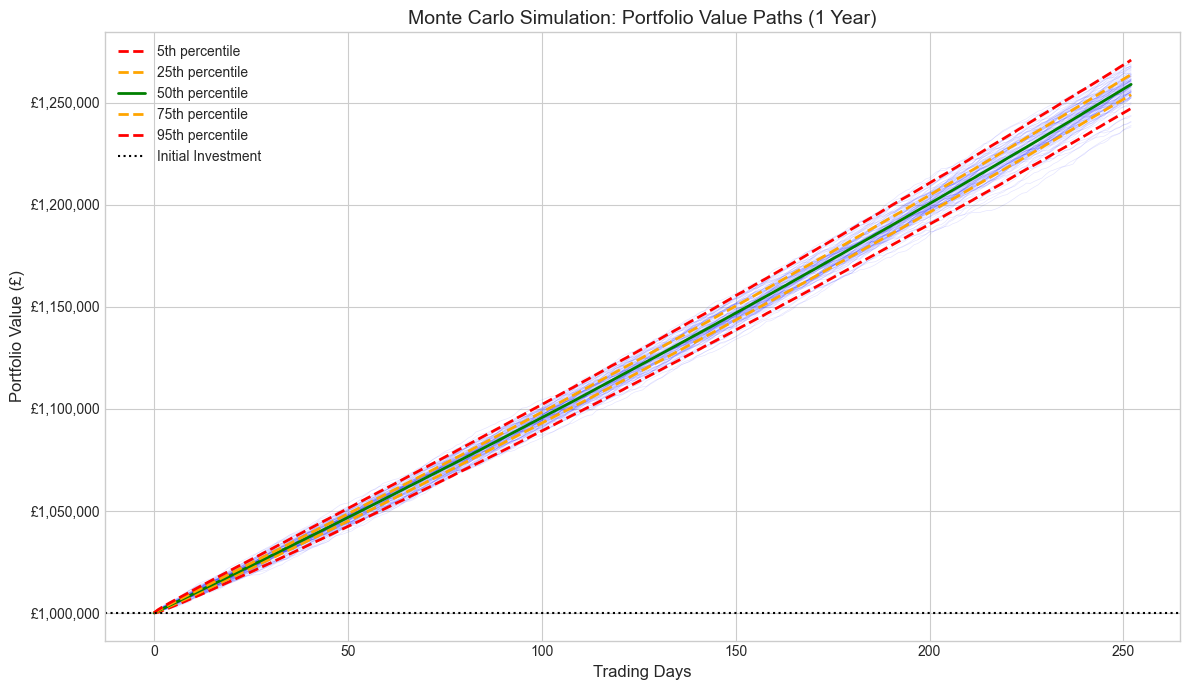

Plot saved to outputs/monte_carlo_paths.png


In [ ]:
# Plot sample paths
fig, ax = plt.subplots(figsize=(12, 7))

# Plot a random sample of paths 
n_sample_paths = 100
sample_indices = np.random.choice(n_simulations, n_sample_paths, replace=False)

for idx in sample_indices:
    ax.plot(portfolio_paths[idx, :], alpha=0.1, color='blue', linewidth=0.5)

# Plot percentiles
percentiles = [5, 25, 50, 75, 95]
colors = ['red', 'orange', 'green', 'orange', 'red']
linestyles = ['--', '--', '-', '--', '--']

for p, color, ls in zip(percentiles, colors, linestyles):
    percentile_path = np.percentile(portfolio_paths, p, axis=0)
    ax.plot(percentile_path, color=color, linestyle=ls, linewidth=2, 
            label=f'{p}th percentile')

ax.axhline(y=initial_investment, color='black', linestyle=':', linewidth=1.5, 
           label='Initial Investment')

ax.set_xlabel('Trading Days', fontsize=12)
ax.set_ylabel('Portfolio Value (£)', fontsize=12)
ax.set_title('Monte Carlo Simulation: Portfolio Value Paths (1 Year)', fontsize=14)
ax.legend(loc='upper left')

# Format y-axis with commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

plt.tight_layout()
plt.savefig('../outputs/monte_carlo_paths.png', dpi=150)
plt.show()

print("Plot saved to outputs/monte_carlo_paths.png")

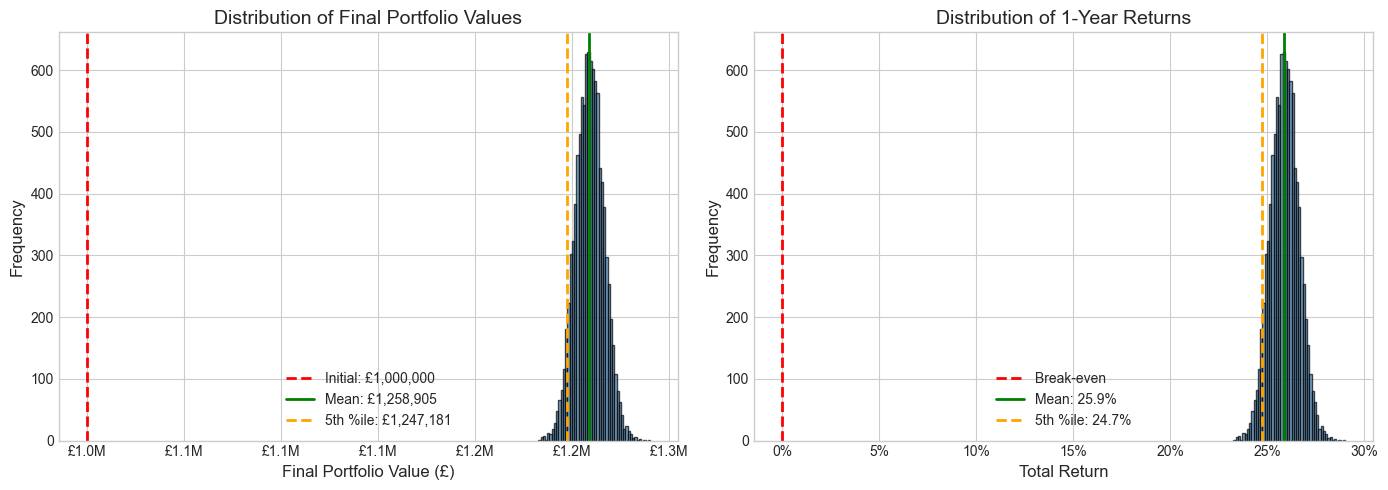

Plot saved to outputs/monte_carlo_distributions.png


In [8]:
# Distribution of final portfolio values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of final values
ax1 = axes[0]
ax1.hist(final_values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=initial_investment, color='red', linestyle='--', linewidth=2, 
            label=f'Initial: £{initial_investment:,.0f}')
ax1.axvline(x=np.mean(final_values), color='green', linestyle='-', linewidth=2,
            label=f'Mean: £{np.mean(final_values):,.0f}')
ax1.axvline(x=np.percentile(final_values, 5), color='orange', linestyle='--', linewidth=2,
            label=f'5th %ile: £{np.percentile(final_values, 5):,.0f}')

ax1.set_xlabel('Final Portfolio Value (£)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Final Portfolio Values', fontsize=14)
ax1.legend()
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x/1e6:.1f}M'))

# Histogram of returns
ax2 = axes[1]
ax2.hist(total_returns, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax2.axvline(x=np.mean(total_returns), color='green', linestyle='-', linewidth=2,
            label=f'Mean: {np.mean(total_returns):.1%}')
ax2.axvline(x=np.percentile(total_returns, 5), color='orange', linestyle='--', linewidth=2,
            label=f'5th %ile: {np.percentile(total_returns, 5):.1%}')

ax2.set_xlabel('Total Return', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of 1-Year Returns', fontsize=14)
ax2.legend()
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout()
plt.savefig('../outputs/monte_carlo_distributions.png', dpi=150)
plt.show()

print("Plot saved to outputs/monte_carlo_distributions.png")

## 5. Risk Metrics from Simulation

 I calculated forward-looking risk metrics based on our simulated outcomes. This is more robust than parametric methods because it doesn't assume normality.

In [19]:
# Calculate various risk metrics
print("FORWARD-LOOKING RISK METRICS (1-Year Horizon)")
print(f"Initial Investment: £{initial_investment:,.0f}")
print()

# Probability of loss
prob_loss = np.mean(final_values < initial_investment)
print(f"Probability of Loss: {prob_loss:.1%}")
print()

# Value at Risk (VaR) - potential loss at different confidence levels
print("Value at Risk (Potential Loss):")
for confidence in [0.90, 0.95, 0.99]:
    var_percentile = np.percentile(final_values, (1 - confidence) * 100)
    var_loss = initial_investment - var_percentile
    print(f"  {confidence:.0%} VaR: £{var_loss:,.0f} (worst case value: £{var_percentile:,.0f})")

print()

# Conditional VaR (Expected Shortfall)
print("Conditional VaR (Expected loss if VaR is breached):")
for confidence in [0.90, 0.95, 0.99]:
    var_percentile = np.percentile(final_values, (1 - confidence) * 100)
    cvar = np.mean(final_values[final_values <= var_percentile])
    cvar_loss = initial_investment - cvar
    print(f"  {confidence:.0%} CVaR: £{cvar_loss:,.0f} (expected worst case: £{cvar:,.0f})")

FORWARD-LOOKING RISK METRICS (1-Year Horizon)
Initial Investment: £1,000,000

Probability of Loss: 0.0%

Value at Risk (Potential Loss):
  90% VaR: £-249,524 (worst case value: £1,249,524)
  95% VaR: £-247,181 (worst case value: £1,247,181)
  99% VaR: £-242,255 (worst case value: £1,242,255)

Conditional VaR (Expected loss if VaR is breached):
  90% CVaR: £-246,291 (expected worst case: £1,246,291)
  95% CVaR: £-244,135 (expected worst case: £1,244,135)
  99% CVaR: £-239,647 (expected worst case: £1,239,647)


In [10]:
# Percentile table
percentile_values = [1, 5, 10, 25, 50, 75, 90, 95, 99]

percentile_df = pd.DataFrame({
    'Percentile': percentile_values,
    'Portfolio Value': [np.percentile(final_values, p) for p in percentile_values],
    'Total Return': [np.percentile(total_returns, p) for p in percentile_values]
})

percentile_df['Gain/Loss'] = percentile_df['Portfolio Value'] - initial_investment

print("PERCENTILE TABLE")
print("=" * 60)
for _, row in percentile_df.iterrows():
    print(f"{row['Percentile']:3.0f}th %ile: £{row['Portfolio Value']:>12,.0f}  "
          f"({row['Total Return']:>+7.1%})  "
          f"Gain/Loss: £{row['Gain/Loss']:>+10,.0f}")

PERCENTILE TABLE
  1th %ile: £   1,242,255  ( +24.2%)  Gain/Loss: £  +242,255
  5th %ile: £   1,247,181  ( +24.7%)  Gain/Loss: £  +247,181
 10th %ile: £   1,249,524  ( +25.0%)  Gain/Loss: £  +249,524
 25th %ile: £   1,253,874  ( +25.4%)  Gain/Loss: £  +253,874
 50th %ile: £   1,258,916  ( +25.9%)  Gain/Loss: £  +258,916
 75th %ile: £   1,263,755  ( +26.4%)  Gain/Loss: £  +263,755
 90th %ile: £   1,268,187  ( +26.8%)  Gain/Loss: £  +268,187
 95th %ile: £   1,270,878  ( +27.1%)  Gain/Loss: £  +270,878
 99th %ile: £   1,275,820  ( +27.6%)  Gain/Loss: £  +275,820


## 6. Time-Based Analysis

How risk evolves over time which is useful for understanding short-term vs long-term risk profiles.

In [11]:
# Calculate VaR at different time horizons
time_points = [5, 21, 63, 126, 252]  # 1 week, 1 month, 3 months, 6 months, 1 year
time_labels = ['1 Week', '1 Month', '3 Months', '6 Months', '1 Year']

var_95_over_time = []
expected_value_over_time = []
prob_loss_over_time = []

for t in time_points:
    values_at_t = portfolio_paths[:, t]
    var_95 = initial_investment - np.percentile(values_at_t, 5)
    expected = np.mean(values_at_t)
    prob_loss = np.mean(values_at_t < initial_investment)
    
    var_95_over_time.append(var_95)
    expected_value_over_time.append(expected)
    prob_loss_over_time.append(prob_loss)

time_analysis = pd.DataFrame({
    'Time Horizon': time_labels,
    'Days': time_points,
    'Expected Value': expected_value_over_time,
    '95% VaR': var_95_over_time,
    'Prob of Loss': prob_loss_over_time
})

print("RISK METRICS OVER TIME")
print("=" * 70)
for _, row in time_analysis.iterrows():
    print(f"{row['Time Horizon']:>10}: Expected £{row['Expected Value']:>10,.0f} | "
          f"95% VaR £{row['95% VaR']:>8,.0f} | "
          f"P(Loss) {row['Prob of Loss']:>5.1%}")

RISK METRICS OVER TIME
    1 Week: Expected £ 1,004,587 | 95% VaR £  -3,274 | P(Loss)  0.0%
   1 Month: Expected £ 1,019,375 | 95% VaR £ -16,591 | P(Loss)  0.0%
  3 Months: Expected £ 1,059,241 | 95% VaR £ -54,234 | P(Loss)  0.0%
  6 Months: Expected £ 1,122,002 | 95% VaR £-114,458 | P(Loss)  0.0%
    1 Year: Expected £ 1,258,905 | 95% VaR £-247,181 | P(Loss)  0.0%


/var/folders/fp/dgylxy996mn1md9g2zsnmb600000gn/T/ipykernel_28826/1446240710.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


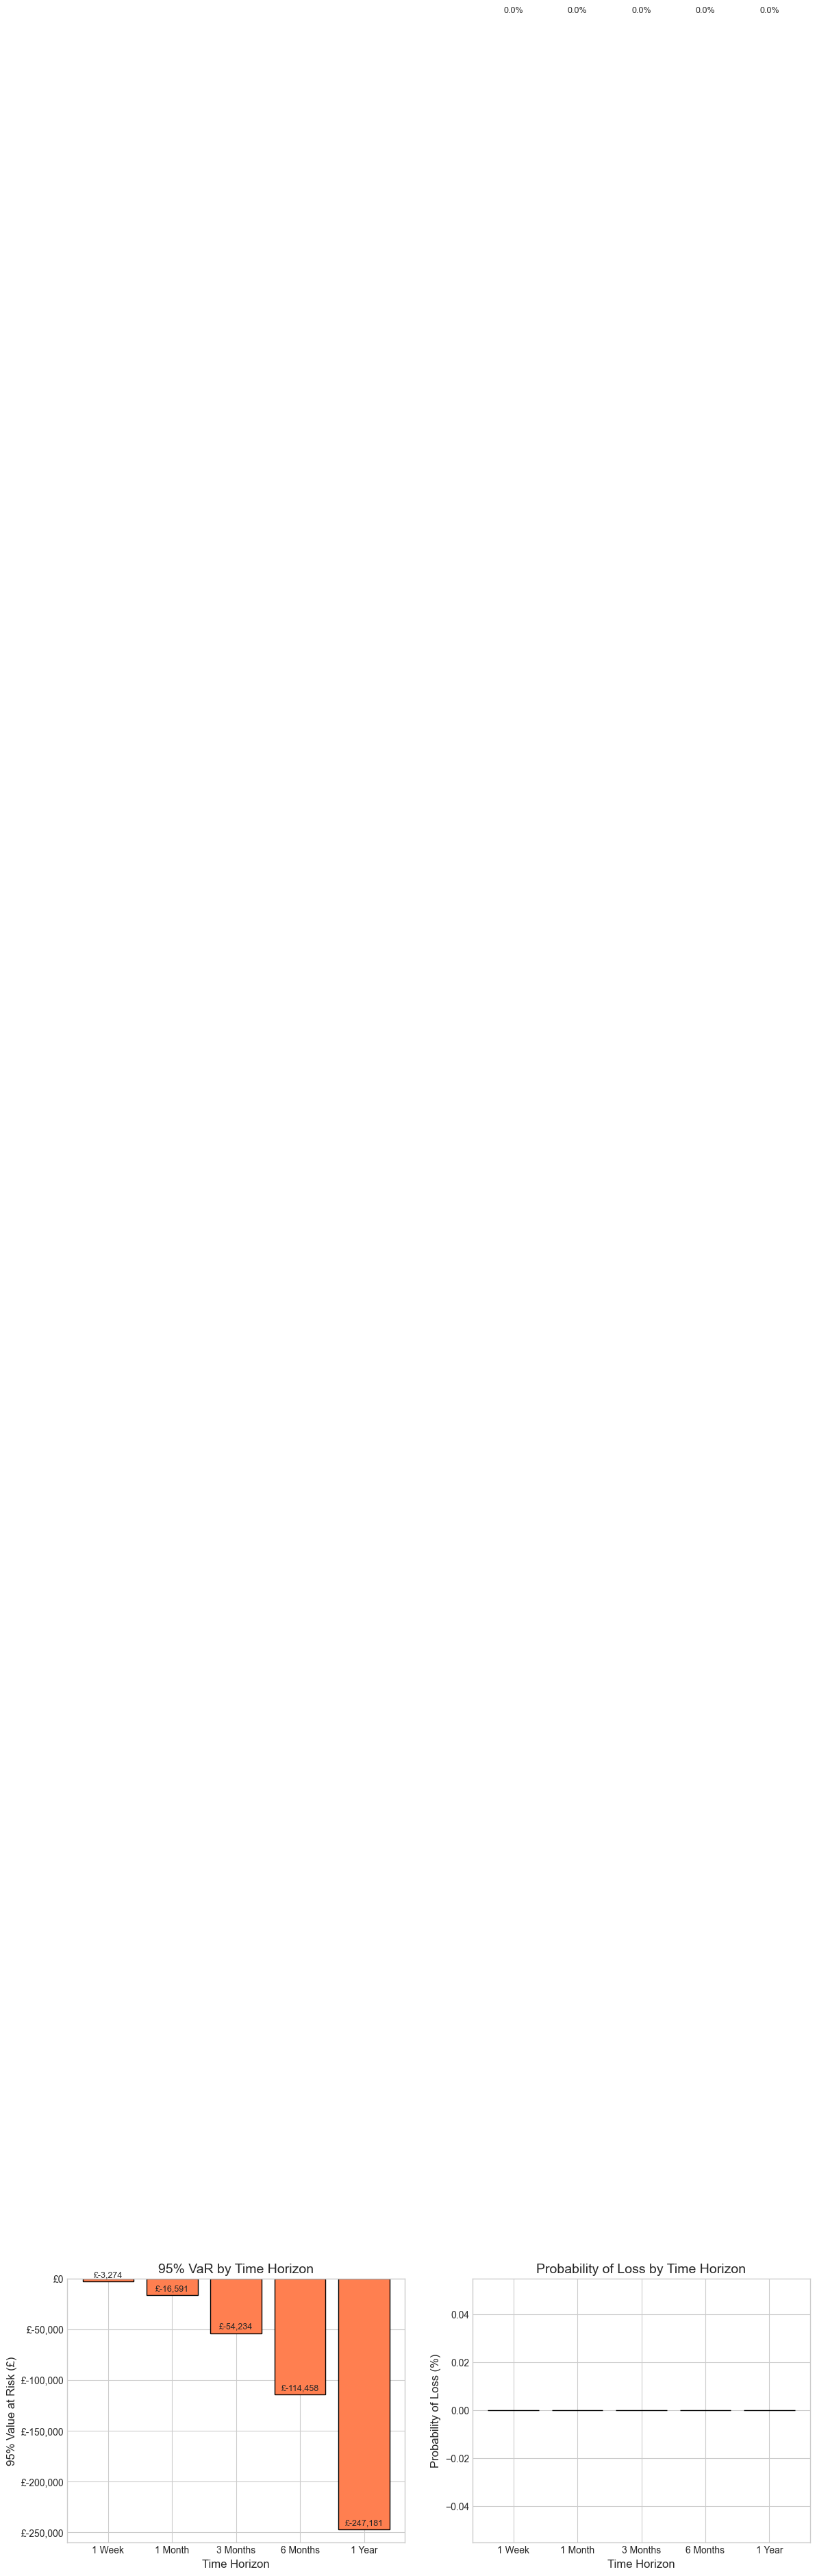

Plot saved to outputs/risk_over_time.png


In [21]:
# Visualise risk over time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# VaR over time
ax1 = axes[0]
ax1.bar(time_labels, var_95_over_time, color='coral', edgecolor='black')
ax1.set_xlabel('Time Horizon', fontsize=12)
ax1.set_ylabel('95% Value at Risk (£)', fontsize=12)
ax1.set_title('95% VaR by Time Horizon', fontsize=14)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

# Add values on bars
for i, v in enumerate(var_95_over_time):
    ax1.text(i, v + 5000, f'£{v:,.0f}', ha='center', fontsize=9)

# Probability of loss over time
ax2 = axes[1]
ax2.bar(time_labels, [p * 100 for p in prob_loss_over_time], color='steelblue', edgecolor='black')
ax2.set_xlabel('Time Horizon', fontsize=12)
ax2.set_ylabel('Probability of Loss (%)', fontsize=12)
ax2.set_title('Probability of Loss by Time Horizon', fontsize=14)

# Add values on bars
for i, v in enumerate(prob_loss_over_time):
    ax2.text(i, v * 100 + 1, f'{v:.1%}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/risk_over_time.png', dpi=150)
plt.show()

print("Plot saved to outputs/risk_over_time.png")

## 7. Stress Testing

Let's see how the portfolio performs under different market scenarios. This is similar to stress testing in insurance capital modelling.

In [13]:
def run_stress_scenario(weights, mean_returns, cov_matrix, initial_value,
                        return_shock=0, volatility_multiplier=1,
                        n_simulations=5000, n_days=252):
    """
    Run simulation under stressed conditions.
    
    Parameters:
    - return_shock: amount to subtract from daily returns (e.g., 0.0005 = 0.05% daily)
    - volatility_multiplier: multiply covariance matrix by this factor
    """
    # Apply stress
    stressed_returns = mean_returns - return_shock
    stressed_cov = cov_matrix * volatility_multiplier
    
    # Run simulation
    paths = simulate_portfolio_gbm(
        weights=weights,
        mean_returns=stressed_returns,
        cov_matrix=stressed_cov,
        initial_value=initial_value,
        n_simulations=n_simulations,
        n_days=n_days
    )
    
    final_values = paths[:, -1]
    
    return {
        'mean': np.mean(final_values),
        'median': np.median(final_values),
        'var_95': initial_value - np.percentile(final_values, 5),
        'prob_loss': np.mean(final_values < initial_value),
        'worst_case': np.percentile(final_values, 1)
    }

print("Stress testing function defined!")

Stress testing function defined!


In [14]:
# Define stress scenarios
scenarios = {
    'Base Case': {'return_shock': 0, 'volatility_multiplier': 1},
    'Mild Stress': {'return_shock': 0.0002, 'volatility_multiplier': 1.25},
    'Moderate Stress': {'return_shock': 0.0005, 'volatility_multiplier': 1.5},
    'Severe Stress': {'return_shock': 0.001, 'volatility_multiplier': 2.0},
    'Crisis': {'return_shock': 0.002, 'volatility_multiplier': 3.0}
}

print("Running stress scenarios...")
print()

stress_results = {}
for name, params in scenarios.items():
    print(f"  Running {name}...")
    stress_results[name] = run_stress_scenario(
        weights=max_sharpe_weights,
        mean_returns=daily_mean_returns,
        cov_matrix=daily_cov_matrix,
        initial_value=initial_investment,
        **params
    )

print("\nStress testing complete!")

Running stress scenarios...

  Running Base Case...
  Running Mild Stress...
  Running Moderate Stress...
  Running Severe Stress...
  Running Crisis...

Stress testing complete!


In [22]:
# Display stress test results
print("STRESS TEST RESULTS")
print("=" * 80)
print(f"{'Scenario':<18} {'Mean Value':>14} {'95% VaR':>12} {'P(Loss)':>10} {'1% Worst':>14}")
print("-" * 80)

for name, results in stress_results.items():
    print(f"{name:<18} £{results['mean']:>12,.0f} £{results['var_95']:>10,.0f} "
          f"{results['prob_loss']:>9.1%} £{results['worst_case']:>12,.0f}")

STRESS TEST RESULTS
Scenario               Mean Value      95% VaR    P(Loss)       1% Worst
--------------------------------------------------------------------------------
Base Case          £   1,258,993 £  -246,971      0.0% £   1,241,473
Mild Stress        £   1,197,073 £  -183,000      0.0% £   1,176,813
Moderate Stress    £   1,109,865 £   -94,485      0.0% £   1,088,694
Severe Stress      £     978,515 £    39,850     97.2% £     952,731
Crisis             £     760,869 £   260,211    100.0% £     731,634


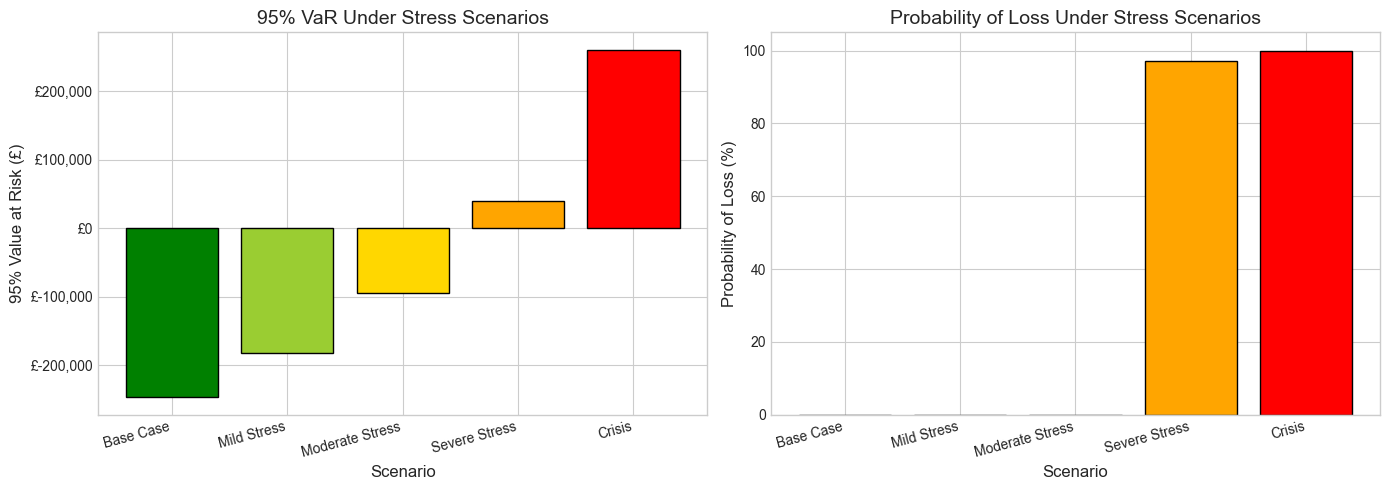

Plot saved to outputs/stress_test_results.png


In [16]:
# Visualise stress test results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scenario_names = list(stress_results.keys())
var_values = [stress_results[s]['var_95'] for s in scenario_names]
prob_values = [stress_results[s]['prob_loss'] * 100 for s in scenario_names]
colors = ['green', 'yellowgreen', 'gold', 'orange', 'red']

# VaR by scenario
ax1 = axes[0]
bars1 = ax1.bar(scenario_names, var_values, color=colors, edgecolor='black')
ax1.set_xlabel('Scenario', fontsize=12)
ax1.set_ylabel('95% Value at Risk (£)', fontsize=12)
ax1.set_title('95% VaR Under Stress Scenarios', fontsize=14)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=15, ha='right')

# Probability of loss by scenario
ax2 = axes[1]
bars2 = ax2.bar(scenario_names, prob_values, color=colors, edgecolor='black')
ax2.set_xlabel('Scenario', fontsize=12)
ax2.set_ylabel('Probability of Loss (%)', fontsize=12)
ax2.set_title('Probability of Loss Under Stress Scenarios', fontsize=14)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')

plt.tight_layout()
plt.savefig('../outputs/stress_test_results.png', dpi=150)
plt.show()

print("Plot saved to outputs/stress_test_results.png")

## 8. Save Results

In [17]:
# Save simulation summary
simulation_summary = pd.DataFrame({
    'Metric': [
        'Initial Investment',
        'Mean Final Value',
        'Median Final Value',
        'Std Deviation',
        'Mean Return',
        'Probability of Loss',
        '95% VaR',
        '99% VaR',
        '95% CVaR',
        '99% CVaR',
        '1st Percentile (Worst)',
        '99th Percentile (Best)'
    ],
    'Value': [
        initial_investment,
        np.mean(final_values),
        np.median(final_values),
        np.std(final_values),
        np.mean(total_returns),
        np.mean(final_values < initial_investment),
        initial_investment - np.percentile(final_values, 5),
        initial_investment - np.percentile(final_values, 1),
        initial_investment - np.mean(final_values[final_values <= np.percentile(final_values, 5)]),
        initial_investment - np.mean(final_values[final_values <= np.percentile(final_values, 1)]),
        np.percentile(final_values, 1),
        np.percentile(final_values, 99)
    ]
})

simulation_summary.to_csv('../outputs/monte_carlo_summary.csv', index=False)

# Save stress test results
stress_df = pd.DataFrame(stress_results).T
stress_df.to_csv('../outputs/stress_test_results.csv')

# Save percentile table
percentile_df.to_csv('../outputs/percentile_table.csv', index=False)

print("Results saved to outputs folder:")
print("- monte_carlo_summary.csv")
print("- stress_test_results.csv")
print("- percentile_table.csv")
print("- monte_carlo_paths.png")
print("- monte_carlo_distributions.png")
print("- risk_over_time.png")
print("- stress_test_results.png")

Results saved to outputs folder:
- monte_carlo_summary.csv
- stress_test_results.csv
- percentile_table.csv
- monte_carlo_paths.png
- monte_carlo_distributions.png
- risk_over_time.png
- stress_test_results.png


## Summary

This notebook contains:

1. **Monte Carlo simulation** using Geometric Brownian Motion with correlated asset returns
2. **Simulated 10,000 portfolio paths** over a 1-year horizon
3. **Analysis of the distribution** of potential outcomes
4. **Calculated forward-looking risk metrics**:
   - Value at Risk (VaR) at multiple confidence levels
   - Conditional VaR (Expected Shortfall)
   - Probability of loss
5. **Examined how risk evolves** over different time horizons
6. **Stress tested the portfolio** under various adverse scenarios

**Key Techniques Demonstrated:**
- Monte Carlo simulation 
- Cholesky decomposition for correlated random variables
- Geometric Brownian Motion for asset price modelling
- Non-parametric risk measurement
- Stress testing and scenario analysis

